In [0]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Download the dataset from Kaggle

In [0]:
# importing the json file
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the cats vs dogs dataset from kaggle
!kaggle competitions download -c dogs-vs-cats

# unzip required files
!unzip "/content/train.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      

## Create dataset from filenames

In [0]:
class dataset_from_filenames(Dataset):
    
    def __init__(self,root_dir, transforms):
        
        self.image_filenames = []
        self.labels = []
        self.transforms = transforms
        
        for filename in os.listdir(root_dir):
            self.image_filenames.append(os.path.join(root_dir,filename))
            
            if filename.startswith('cat'):
                self.labels.append(0)
            elif filename.startswith('dog'):
                self.labels.append(1)
    
    # You must override __getitem__ and __len__
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self,index):
        image = Image.open(self.image_filenames[index])
        image = self.transforms(image)  
        return image, self.labels[index]    

## Apply transformations to image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total number of Images: 25000
Number of cats: 12500
Number of dogs: 12500
torch.Size([3, 224, 224])
Label: 0


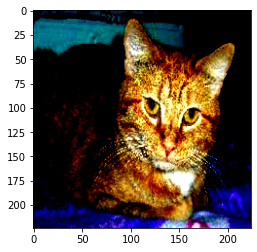

In [0]:
# define the transformations
image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

train_dataset = dataset_from_filenames('train', image_transforms)

print('Total number of Images: {}'.format(len(train_dataset)))
print('Number of cats: {}'.format(train_dataset.labels.count(0)))
print('Number of dogs: {}'.format(train_dataset.labels.count(1)))

######################## Visualise Transformations #######################
image, label = train_dataset[0]
print(image.shape)
print('Label: {}'.format(label))

plt.imshow(image.numpy().transpose(1,2,0))

## Split the dataset and make random batches

In [0]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(train_dataset))
len_test_set = int(0.1*len(train_dataset))
new_len_train_set = len(train_dataset) - len_valid_set - len_test_set

print("The length of Train set is {}".format(new_len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


train_dataset , valid_dataset , test_dataset = torch.utils.data.random_split(train_dataset , 
                                                                   [new_len_train_set,
                                                                    len_valid_set,  
                                                                    len_test_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,shuffle=True)

images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

The length of Train set is 20000
The length of Valid set is 2500
The length of Test set is 2500
torch.Size([128, 3, 224, 224])
torch.Size([128])


## Make the model

In [0]:
resnet_model = models.resnet50(pretrained=True)
print(resnet_model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

We need to change the fc layer in Resnet 50 since we have 2 classes

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        self.feature_extractor = models.resnet50(pretrained=True)
 
        self.feature_extractor.fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(2048, 256)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(256, 2))
        ]))
        
    def forward(self,x):      
        x = self.feature_extractor(x)
        return x
    
network = Network()
network.cuda()
print(network)

Network(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [0]:
print(network.feature_extractor.fc.parameters)

<bound method Module.parameters of Sequential(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)>


# Function to overwrite the console output

In [0]:
import sys

def print_overwrite(step, total_step, loss, mean_iou, operation):
    sys.stdout.write('\r')
    
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, mean_iou))
        
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, mean_iou))
        
    sys.stdout.flush()

## Training

In [0]:
num_epochs = 5
acc_max = 0

# function to find the accuracy
def find_acc(pred, label):
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item()
    return accuracy

# loss defined using torch.nn
criterion = nn.CrossEntropyLoss()

# define the optimizer
# only weights of fc layer has to be updated
optimizer = optim.Adam(network.feature_extractor.fc.parameters(), lr=0.01)

# note the starting time to find the total time elapsed
start_time = time.time()

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    acc_train = 0
    acc_valid = 0
    running_loss = 0
    running_acc = 0
    
    # set the network into train mode
    network.train()
    
    for step in range(1,len(train_loader)+1):
    
        images, labels = next(iter(train_loader))
        
        # move the images and labels to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        logits = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss and acc for the current step
        loss_train_step = criterion(logits, labels)
        acc_train_step = find_acc(logits, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        acc_train += acc_train_step 
        running_loss = loss_train/step
        running_accuracy = acc_train/step
        
        print_overwrite(step, len(train_loader), running_loss, running_accuracy, 'train')
        
    network.eval() 
    
    # turn the gradients off for validation
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, labels = next(iter(valid_loader))

            # move the images and labels to GPU
            images = images.cuda()
            labels = labels.cuda()

            logits = network(images)

            # clear all the gradients before calculating them
            optimizer.zero_grad()

            # find the loss and acc for the current step
            loss_valid_step = criterion(logits , labels)
            acc_valid_step = find_acc(logits, labels)

            loss_valid += loss_valid_step.item()
            acc_valid += acc_valid_step
            running_loss = loss_valid/step
            running_accuracy = acc_valid/step
            print_overwrite(step, len(valid_loader), running_loss, running_accuracy, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
   
    acc_train /= len(train_loader)
    acc_valid /= len(valid_loader)
    
    print('\n------------------------------------------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))
    print('------------------------------------------------------------------------------------')
    
    if acc_valid > acc_max:
        acc_max = acc_valid
        torch.save(network.state_dict(), 'cat_vs_dog.pth') 
        print("\nMaximum validation accuracy of {} at epoch {}/{}".format(acc_max, epoch, num_epochs))
        print('Model Saved\n')
    
# find the time at the end of training    
end_time = time.time()

print('Training Complete')
print("Total time taken : {} s".format(end_time - start_time))

Valid Steps: 20/20  Loss: 0.0786  Accuracy: 0.9656
------------------------------------------------------------------------------------
Epoch: 1  Train Loss: 0.4087  Train Acc: 0.9377  Valid Loss: 0.0786  Valid Acc: 0.9656
------------------------------------------------------------------------------------

Maximum validation accuracy of 0.965625 at epoch 1/5
Model Saved

Valid Steps: 20/20  Loss: 0.0593  Accuracy: 0.9762
------------------------------------------------------------------------------------
Epoch: 2  Train Loss: 0.0638  Train Acc: 0.9748  Valid Loss: 0.0593  Valid Acc: 0.9762
------------------------------------------------------------------------------------

Maximum validation accuracy of 0.976171875 at epoch 2/5
Model Saved

Valid Steps: 20/20  Loss: 0.0607  Accuracy: 0.9750
------------------------------------------------------------------------------------
Epoch: 3  Train Loss: 0.0544  Train Acc: 0.9795  Valid Loss: 0.0607  Valid Acc: 0.9750
------------------------

KeyboardInterrupt: ignored

## Load the best saved model 

In [0]:
best_network = Network()
best_network.cuda()
best_network.load_state_dict(torch.load('cat_vs_dog.pth')) 
best_network.eval()

Network(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


## Test the best_network on the test dataset

In [0]:
def test_model(model):
    
    start_time = time.time()
    num_correct = 0
    accuracy = 0

    with torch.no_grad():
        for images, labels in test_loader:
            
            images = images.cuda()
            labels = labels.cuda()

            total_images = len(test_dataset)
            logits = model(images)

            num_correct_batch = logits.argmax(dim = 1).eq(labels).sum().item()
            accuracy_batch = logits.argmax(dim = 1).eq(labels).float().mean().item()
            
            num_correct += num_correct_batch
            accuracy += accuracy_batch

        accuracy /= len(test_loader)

    print('Total number of test images: {}'.format(total_images))
    print('Total number of correct predictions: {}'.format(num_correct))
    print('Accuracy: {}'.format(accuracy * 100))

    end_time = time.time()
    print("Elapsed Time : {}".format(end_time - start_time))
    
test_model(best_network)    

Total number of test images: 2500
Total number of correct predictions: 2452
Accuracy: 98.125
Elapsed Time : 30.80606245994568


###Start with a zeros image as input

In [0]:
optimal_image = torch.zeros((1,3,224,224), requires_grad=True, device="cuda")

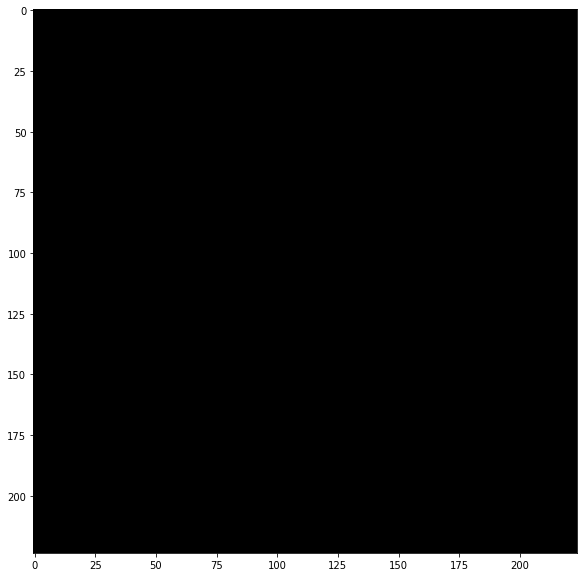

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(optimal_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0))

###Update the image to minimise the loss

In [0]:
num_epochs = 100

labels = torch.tensor([1]).cuda()

# loss defined using torch.nn
criterion = nn.CrossEntropyLoss()

# define the optimizer
# only the input image has to be updated
gen_optimizer = optim.Adam([optimal_image], lr=0.01)

# note the starting time to find the total time elapsed
start_time = time.time()

for epoch in range(1,num_epochs+1):
    
    loss_gen = 0
    
    # set the network into train mode
    network.train()
     
    logits = best_network(optimal_image)
    
    # clear all the gradients before calculating them
    gen_optimizer.zero_grad()
    
    # find the loss and acc for the current step
    loss_gen_step = criterion(logits, labels)
    
    # calculate the gradients
    loss_gen_step.backward()
    
    # update the parameters
    gen_optimizer.step()
    
    loss_gen += loss_gen_step.item()
    
    print('\n-------------------------------------------')
    print('Epoch: {}  Generation Loss: {:.4f}'.format(epoch, loss_gen))

# find the time at the end of training    
end_time = time.time()

print('Generation Complete')
print("Total time taken : {} s".format(end_time - start_time))


-------------------------------------------
Epoch: 1  Generation Loss: 0.0002

-------------------------------------------
Epoch: 2  Generation Loss: 0.0000

-------------------------------------------
Epoch: 3  Generation Loss: 0.0000

-------------------------------------------
Epoch: 4  Generation Loss: 0.0000

-------------------------------------------
Epoch: 5  Generation Loss: 0.0000

-------------------------------------------
Epoch: 6  Generation Loss: 0.0000

-------------------------------------------
Epoch: 7  Generation Loss: 0.0000

-------------------------------------------
Epoch: 8  Generation Loss: 0.0000

-------------------------------------------
Epoch: 9  Generation Loss: 0.0000

-------------------------------------------
Epoch: 10  Generation Loss: 0.0000

-------------------------------------------
Epoch: 11  Generation Loss: 0.0000

-------------------------------------------
Epoch: 12  Generation Loss: 0.0000

-------------------------------------------
Epoc

###Updated image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


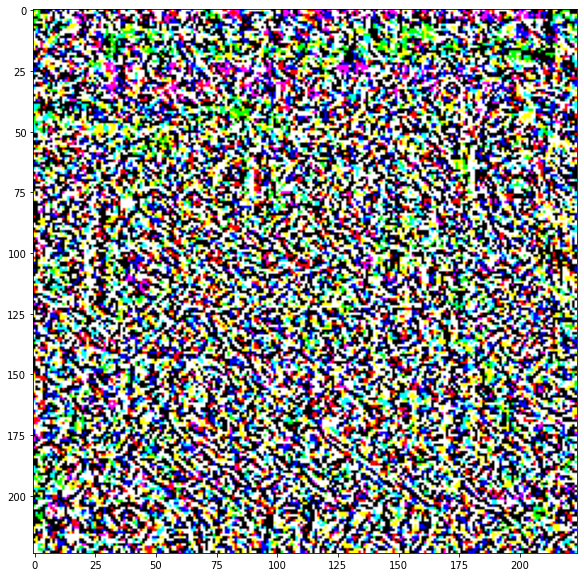

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(optimal_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0))